✅ Loaded shapes: flights (8099, 15) pnr_flight (687878, 12) pnr_remarks (51698, 4) bags (687245, 8)
Available special passenger columns: ['lap_child_count', 'is_child', 'is_stroller_user']
Available bag types: ['hot_transfer_bags', 'origin_bags', 'transfer_bags']
✅ merged_ssr ready: (8099, 34)


/var/folders/1c/vd0n01815sq9yfg19swh9n340000gn/T/ipykernel_10007/1695486357.py:301: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(daily_score)


✅ Enhanced daily scoring done: (8099, 46)

Top 20 most difficult flights on 2025-08-01:
 flight_number  difficulty_score  rank  category  total_pax  weighted_baggage  bags_per_pax  ground_time_gap  has_ssr  special_needs_pax  load_factor
           972         25.790255     1 Difficult        357             759.5      2.127451              591       10               23.3   112.264151
           944         15.940496     2 Difficult        399             410.0      1.027569               95        2               34.7   125.471698
           845         15.116406     3 Difficult        367             449.5      1.224796              205       10               28.5   115.408805
           907         14.639318     4 Difficult        399             411.0      1.030075               55        5               36.8   125.471698
          5260         14.270975     5 Difficult         31              67.0      2.161290               34        1                1.2    62.000000
           2

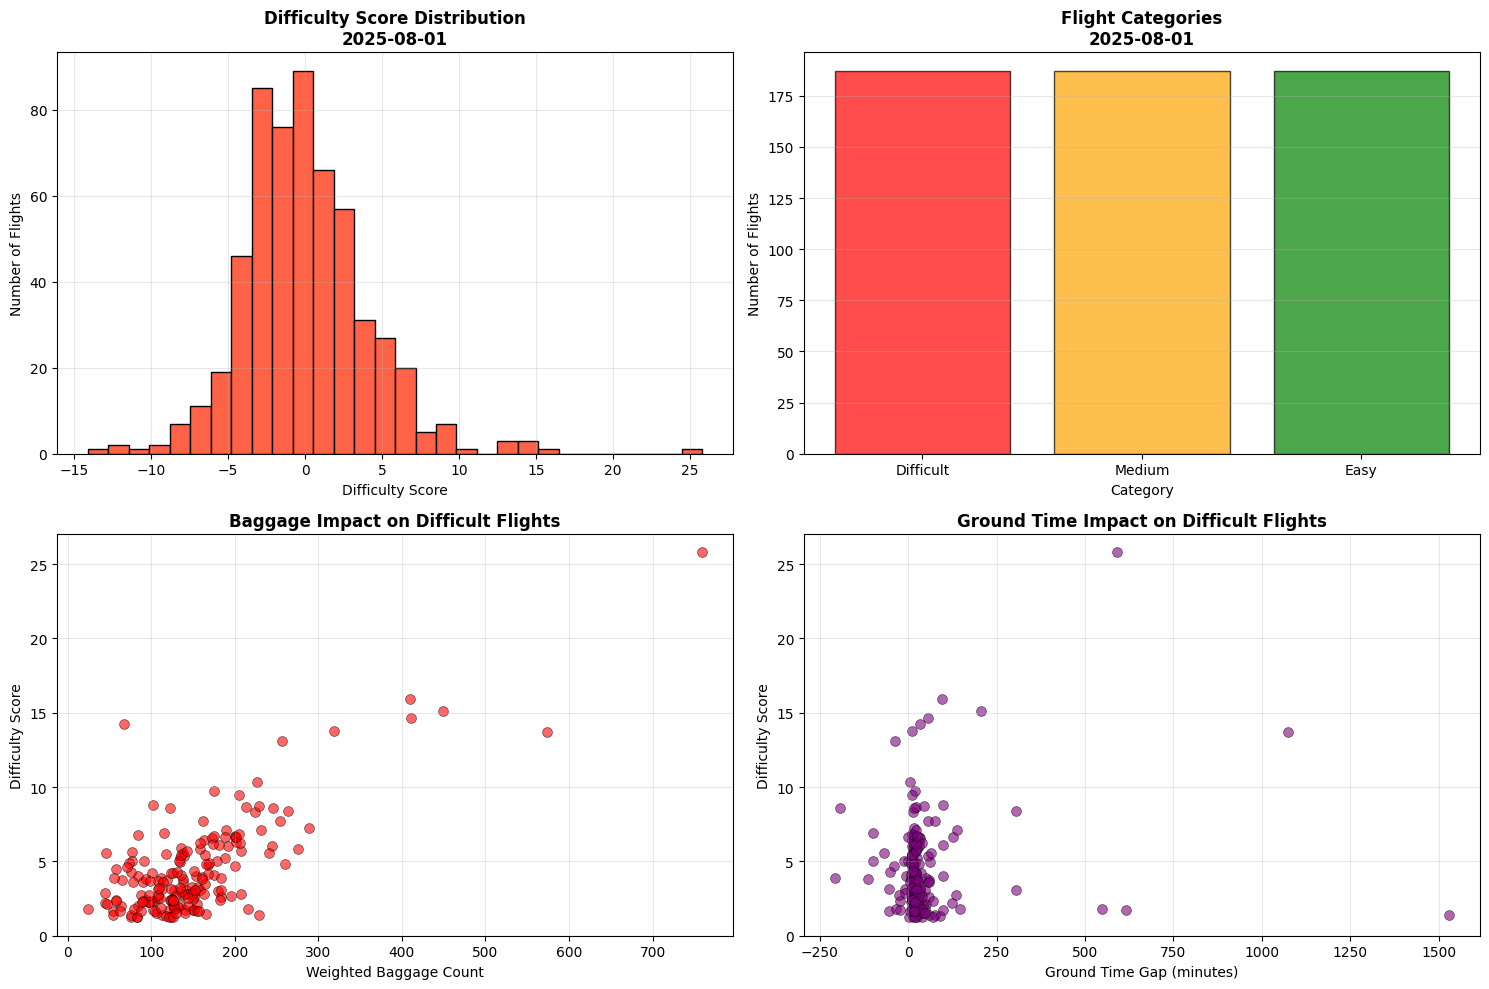


✅ Analysis complete. Results saved to outputs folder.
   - Visualization: enhanced_difficulty_analysis.png
   - Full dataset: flight_difficulty_scores.csv

📊 Summary Statistics for 2025-08-01:
   Total flights: 561
   Difficult: 187 flights
   Medium: 187 flights
   Easy: 187 flights
   Avg difficulty score: 0.00
   Total passengers: 77,387
   Total weighted bags: 52,628


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
os.makedirs("../outputs", exist_ok=True)

flights = pd.read_csv(
    "../data/flights.csv",
    parse_dates=[
        "scheduled_departure_date_local",
        "scheduled_departure_datetime_local",
        "actual_departure_datetime_local"
    ]
)

pnr_flight = pd.read_csv(
    "../data/pnr_flight.csv",
    parse_dates=["pnr_creation_date", "scheduled_departure_date_local"]
)

pnr_remarks = pd.read_csv(
    "../data/pnr_remarks.csv",
    parse_dates=["pnr_creation_date"]
)

# Load baggage data
bags = pd.read_csv(
    "../data/bags.csv",
    parse_dates=["scheduled_departure_date_local"]
)

print("✅ Loaded shapes:",
      "flights", flights.shape,
      "pnr_flight", pnr_flight.shape,
      "pnr_remarks", pnr_remarks.shape,
      "bags", bags.shape)

# Feature engineering
flights["flight_date"] = flights["scheduled_departure_date_local"].dt.normalize()

flights["departure_delay"] = (
    flights["actual_departure_datetime_local"]
    - flights["scheduled_departure_datetime_local"]
).dt.total_seconds() / 60

flights["ground_time_gap"] = (
    flights["scheduled_ground_time_minutes"]
    - flights["minimum_turn_minutes"]
)

# NEW: Extract time of day (hour) for operational complexity
flights["departure_hour"] = flights["scheduled_departure_datetime_local"].dt.hour

# Aggregate passenger load from PNR data
pax = (
    pnr_flight
    .groupby(["flight_number", "scheduled_departure_date_local"])
    ["total_pax"]
    .sum()
    .reset_index()
    .rename(columns={"scheduled_departure_date_local": "flight_date"})
)

# NEW: Count special passenger needs from PNR data
# Only aggregate columns that actually exist in the dataset
special_pax_cols = {}
if "lap_child_count" in pnr_flight.columns:
    special_pax_cols["lap_child_count"] = "sum"
if "is_child" in pnr_flight.columns:
    special_pax_cols["is_child"] = "sum"
if "basic_economy_pax" in pnr_flight.columns:
    special_pax_cols["basic_economy_pax"] = "sum"
if "is_stroller_user" in pnr_flight.columns:
    special_pax_cols["is_stroller_user"] = "sum"

if special_pax_cols:
    special_pax = (
        pnr_flight
        .groupby(["flight_number", "scheduled_departure_date_local"])
        .agg(special_pax_cols)
        .reset_index()
        .rename(columns={"scheduled_departure_date_local": "flight_date"})
    )
else:
    # Create empty dataframe if no special pax columns exist
    special_pax = pd.DataFrame({
        "flight_number": [],
        "flight_date": []
    })

print("Available special passenger columns:", list(special_pax_cols.keys()))

# NEW: Process baggage data with proper bag types
# Create flight_date for bags
bags["flight_date"] = pd.to_datetime(bags["scheduled_departure_date_local"]).dt.normalize()

# Separate transfer bags (hot transfers are < 30 min connection)
# From schema: *Hot transfer bags are transfer bags with a connection time of less than 30 minutes
baggage = (
    bags
    .groupby(["flight_number", "flight_date", "bag_type"])
    .size()
    .reset_index(name="bag_count")
)

# Pivot to get different bag types as columns
baggage_pivot = baggage.pivot_table(
    index=["flight_number", "flight_date"],
    columns="bag_type",
    values="bag_count",
    fill_value=0
).reset_index()

# Rename columns to be more descriptive
baggage_pivot.columns.name = None
bag_cols = {col: col.lower().replace(" ", "_") + "_bags" 
            for col in baggage_pivot.columns if col not in ["flight_number", "flight_date"]}
baggage_pivot.rename(columns=bag_cols, inplace=True)

print("Available bag types:", [col for col in baggage_pivot.columns if 'bags' in col])

# Merge all data sources
merged_df = (
    flights
    .merge(pax, on=["flight_number", "flight_date"], how="left")
    .merge(special_pax, on=["flight_number", "flight_date"], how="left")
    .merge(baggage_pivot, on=["flight_number", "flight_date"], how="left")
)

# Fill NaN values for passenger data
merged_df["total_pax"] = merged_df["total_pax"].fillna(0).astype(int)

# Fill special passenger columns only if they exist
# Note: is_child and is_stroller_user are boolean columns (Y/N), need to count 'Y' values
if "lap_child_count" in merged_df.columns:
    merged_df["lap_child_count"] = merged_df["lap_child_count"].fillna(0).astype(int)
else:
    merged_df["lap_child_count"] = 0

if "is_child" in merged_df.columns:
    # is_child is a string column with 'Y'/'N' values per passenger in PNR
    # We need to count how many 'Y' values there are
    merged_df["is_child"] = merged_df["is_child"].fillna(0)
    # If it's an object/string type, count 'Y' occurrences
    if merged_df["is_child"].dtype == 'object':
        merged_df["child_count"] = merged_df["is_child"].apply(
            lambda x: str(x).count('Y') if pd.notna(x) else 0
        )
    else:
        merged_df["child_count"] = merged_df["is_child"].fillna(0).astype(int)
else:
    merged_df["child_count"] = 0

if "basic_economy_pax" in merged_df.columns:
    merged_df["basic_economy_pax"] = merged_df["basic_economy_pax"].fillna(0).astype(int)
else:
    merged_df["basic_economy_pax"] = 0

if "is_stroller_user" in merged_df.columns:
    # Similar handling for is_stroller_user
    merged_df["is_stroller_user"] = merged_df["is_stroller_user"].fillna(0)
    if merged_df["is_stroller_user"].dtype == 'object':
        merged_df["stroller_count"] = merged_df["is_stroller_user"].apply(
            lambda x: str(x).count('Y') if pd.notna(x) else 0
        )
    else:
        merged_df["stroller_count"] = merged_df["is_stroller_user"].fillna(0).astype(int)
else:
    merged_df["stroller_count"] = 0

# Fill baggage columns (they vary by dataset)
for col in baggage_pivot.columns:
    if 'bags' in col and col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(0).astype(int)

# Calculate weighted baggage complexity
# Transfer bags are MUCH harder operationally (2.0x weight)
# Hot transfer bags are even harder due to tight connection times (2.5x weight)
merged_df["weighted_baggage"] = 0

if "checked_bags" in merged_df.columns:
    merged_df["weighted_baggage"] += merged_df["checked_bags"] * 1.0

if "transfer_bags" in merged_df.columns:
    merged_df["weighted_baggage"] += merged_df["transfer_bags"] * 2.0

if "hot_transfer_bags" in merged_df.columns:
    merged_df["weighted_baggage"] += merged_df["hot_transfer_bags"] * 2.5

# Calculate bags per passenger ratio
merged_df["bags_per_pax"] = np.where(
    merged_df["total_pax"] > 0,
    merged_df["weighted_baggage"] / merged_df["total_pax"],
    0
)

# Calculate special needs complexity using the counted values
merged_df["special_needs_pax"] = (
    merged_df["lap_child_count"] * 1.5 +      # Lap children need extra attention
    merged_df["child_count"] * 1.2 +          # Unaccompanied minors
    merged_df["stroller_count"] * 1.3         # Strollers add gate complexity
)

# Calculate load factor (capacity utilization)
merged_df["load_factor"] = np.where(
    merged_df["total_seats"] > 0,
    (merged_df["total_pax"] / merged_df["total_seats"]) * 100,
    0
)

# SSR counts (your existing code)
ssr = (
    pnr_remarks
    .merge(
        pnr_flight[["record_locator", "pnr_creation_date", "scheduled_departure_date_local"]],
        on=["record_locator", "pnr_creation_date"],
        how="left"
    )
    .rename(columns={"scheduled_departure_date_local": "flight_date"})
)

ssr["has_ssr"] = ssr["special_service_request"].notna().astype(int)
ssr_counts = (
    ssr
    .groupby(["flight_number", "flight_date"])
    ["has_ssr"]
    .sum()
    .reset_index()
)

merged_ssr = (
    merged_df
    .merge(ssr_counts, on=["flight_number", "flight_date"], how="left")
    .assign(has_ssr=lambda df: df["has_ssr"].fillna(0).astype(int))
)

print("✅ merged_ssr ready:", merged_ssr.shape)


# ENHANCED: Daily scoring function with comprehensive factors
def daily_score(df):
    df = df.copy()
    
    # Define features to normalize
    features = [
        "departure_delay",        # Historical delay (operational indicator)
        "total_pax",             # Passenger volume
        "ground_time_gap",       # Time pressure (inverse)
        "weighted_baggage",      # Baggage complexity (transfer + hot transfer weighted)
        "bags_per_pax",          # Operational intensity per passenger
        "has_ssr",               # Special service requests
        "special_needs_pax",     # Passengers needing extra attention
        "load_factor",           # How full the flight is
        "departure_hour"         # Time of day impact
    ]
    
    # Z-score normalization for each feature
    for col in features:
        if col in df.columns:
            m, s = df[col].mean(), df[col].std(ddof=0)
            if s > 0:  # Avoid division by zero
                df[f"z_{col}"] = (df[col] - m) / s
            else:
                df[f"z_{col}"] = 0
        else:
            df[f"z_{col}"] = 0
    
    # ENHANCED: Composite difficulty score with operational weights
    # Weights based on operational impact (adjust based on frontline feedback)
    df["difficulty_score"] = (
        df["z_departure_delay"] * 1.3 +        # Past delays predict issues (high weight)
        df["z_total_pax"] * 1.0 +              # More passengers = more complexity
        -df["z_ground_time_gap"] * 1.4 +       # Less ground time = harder (highest weight)
        df["z_weighted_baggage"] * 1.5 +       # Baggage (esp. transfers) = major factor
        df["z_bags_per_pax"] * 0.9 +           # Bags per passenger intensity
        df["z_has_ssr"] * 0.7 +                # Special service needs
        df["z_special_needs_pax"] * 0.8 +      # Children, lap infants, strollers
        df["z_load_factor"] * 0.6 +            # Fuller flights harder to board
        df["z_departure_hour"] * 0.4           # Time of day (peak vs off-peak)
    )
    
    # Rank (1 = hardest)
    df["rank"] = df["difficulty_score"].rank(method="first", ascending=False).astype(int)
    
    # Tercile classification
    df["category"] = pd.qcut(
        df["difficulty_score"], 
        q=3,
        labels=["Easy", "Medium", "Difficult"]
    )
    
    return df


# Apply per day
daily = (
    merged_ssr
    .groupby("flight_date", group_keys=False)
    .apply(daily_score)
    .reset_index(drop=True)
)

print("✅ Enhanced daily scoring done:", daily.shape)

# Sample output for first date
sample_day = daily["flight_date"].min()
day_df = daily[daily["flight_date"] == sample_day]

print(f"\nTop 20 most difficult flights on {sample_day.date()}:")
output_cols = [
    "flight_number", "difficulty_score", "rank", "category",
    "total_pax", "weighted_baggage", "bags_per_pax", "ground_time_gap",
    "has_ssr", "special_needs_pax", "load_factor"
]
# Only include columns that exist
output_cols = [col for col in output_cols if col in day_df.columns]

print(
    day_df[output_cols]
    .sort_values("rank")
    .head(20)
    .to_string(index=False)
)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Difficulty score distribution
axes[0, 0].hist(day_df["difficulty_score"], bins=30, color="tomato", edgecolor="black")
axes[0, 0].set_title(f"Difficulty Score Distribution\n{sample_day.date()}", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Difficulty Score")
axes[0, 0].set_ylabel("Number of Flights")
axes[0, 0].grid(alpha=0.3)

# 2. Category breakdown
category_counts = day_df["category"].value_counts().reindex(["Difficult", "Medium", "Easy"])
axes[0, 1].bar(category_counts.index, category_counts.values, 
               color=["red", "orange", "green"], edgecolor="black", alpha=0.7)
axes[0, 1].set_title(f"Flight Categories\n{sample_day.date()}", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Number of Flights")
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Baggage vs Difficulty (if baggage data exists)
if day_df["weighted_baggage"].sum() > 0:
    difficult_flights = day_df[day_df["category"] == "Difficult"]
    axes[1, 0].scatter(difficult_flights["weighted_baggage"], 
                       difficult_flights["difficulty_score"],
                       alpha=0.6, color="red", s=50, edgecolor="black", linewidth=0.5)
    axes[1, 0].set_title("Baggage Impact on Difficult Flights", fontsize=12, fontweight="bold")
    axes[1, 0].set_xlabel("Weighted Baggage Count")
    axes[1, 0].set_ylabel("Difficulty Score")
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, "No baggage data available", 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title("Baggage Data", fontsize=12, fontweight="bold")

# 4. Ground time vs Difficulty
difficult_flights = day_df[day_df["category"] == "Difficult"]
axes[1, 1].scatter(difficult_flights["ground_time_gap"], 
                   difficult_flights["difficulty_score"],
                   alpha=0.6, color="purple", s=50, edgecolor="black", linewidth=0.5)
axes[1, 1].set_title("Ground Time Impact on Difficult Flights", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Ground Time Gap (minutes)")
axes[1, 1].set_ylabel("Difficulty Score")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/enhanced_difficulty_analysis.png", dpi=300)
plt.show()

# Save detailed results
daily.to_csv("../outputs/flight_difficulty_scores.csv", index=False)
print(f"\n✅ Analysis complete. Results saved to outputs folder.")
print(f"   - Visualization: enhanced_difficulty_analysis.png")
print(f"   - Full dataset: flight_difficulty_scores.csv")

# Summary statistics
print(f"\n📊 Summary Statistics for {sample_day.date()}:")
print(f"   Total flights: {len(day_df)}")
print(f"   Difficult: {len(day_df[day_df['category']=='Difficult'])} flights")
print(f"   Medium: {len(day_df[day_df['category']=='Medium'])} flights")
print(f"   Easy: {len(day_df[day_df['category']=='Easy'])} flights")
print(f"   Avg difficulty score: {day_df['difficulty_score'].mean():.2f}")
print(f"   Total passengers: {day_df['total_pax'].sum():,}")
if day_df["weighted_baggage"].sum() > 0:
    print(f"   Total weighted bags: {day_df['weighted_baggage'].sum():,.0f}")